In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/edgeiiotdataset/EdgeIioTDataset/val.csv
/kaggle/input/edgeiiotdataset/EdgeIioTDataset/train.csv
/kaggle/input/edgeiiotdataset/EdgeIioTDataset/test.csv


In [6]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from keras import regularizers

In [10]:
train_df = pd.read_csv('/kaggle/input/edgeiiotdataset/EdgeIioTDataset/train.csv')
val_df = pd.read_csv('/kaggle/input/edgeiiotdataset/EdgeIioTDataset/val.csv')

In [11]:
# Drop the binary label
for df in (train_df, val_df):
    df.drop(columns=['Attack_label'], inplace=True, errors='ignore')

In [12]:
# Features / target
FEATURE_COLS = [c for c in train_df.columns if c != 'Attack_type']

In [13]:
# Train
X_train = train_df[FEATURE_COLS].astype('float32').values
y_train_lbl = train_df['Attack_type'].astype(int).values

In [14]:
# Val
X_val = val_df[FEATURE_COLS].astype('float32').values
y_val_lbl = val_df['Attack_type'].astype(int).values

In [15]:
# One-hot encode the type labels
num_types = len(np.unique(y_train_lbl))
y_train = to_categorical(y_train_lbl, num_classes=num_types)
y_val = to_categorical(y_val_lbl, num_classes=num_types)

In [16]:
# tf.data pipelines
BATCH_SIZE = 128
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(len(X_train)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

I0000 00:00:1749902728.720566      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1749902728.721286      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [17]:
# Define model with Dropout and L2 Regularization

def build_type_model(input_dim, num_types, lr=5e-5):
    inp = Input(shape=(input_dim,), name='features')
    
    # First dense layer with L2 regularization and Dropout
    x = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01))(inp)
    x = Dropout(0.5)(x)  # Apply Dropout
    
    # Second dense layer with L2 regularization and Dropout
    x = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
    x = Dropout(0.5)(x)  # Apply Dropout
    
    # Output layer with softmax for multi-class classification
    out = Dense(num_types, activation='softmax', name='type_output')(x)

    # Compile the model
    model = Model(inp, out)
    model.compile(
        optimizer=Adam(lr),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [18]:
# Create Model
model = build_type_model(X_train.shape[1], num_types)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ features (InputLayer)                │ (None, 249)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │          64,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ type_output (Dense)                  │ (None, 15)                  │           3,855 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 133,647 (522.06 KB)

 Trainable params: 133,647 (522.06 KB)

 Non-trainable params: 0 (0.00 B)

In [19]:
# Checkpoint On Validation Accuracy
CHECKPOINT_PATH = '/kaggle/working/best_type_model.keras'
ckpt = ModelCheckpoint(filepath=CHECKPOINT_PATH,monitor='val_accuracy',mode='max',
    save_best_only=True,
    verbose=1
)

In [20]:
# Training
EPOCHS = 10
history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS,callbacks=[ckpt])

Epoch 1/10


I0000 00:00:1749904938.192938     108 service.cc:148] XLA service 0x79a9b80049c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749904938.195617     108 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1749904938.195638     108 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1749904938.508805     108 cuda_dnn.cc:529] Loaded cuDNN version 90300


   71/11096 ━━━━━━━━━━━━━━━━━━━━ 24s 2ms/step - accuracy: 0.4609 - loss: 7.3190  

I0000 00:00:1749904940.331138     108 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


11090/11096 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8582 - loss: 1.8524
Epoch 1: val_accuracy improved from -inf to 0.92260, saving model to /kaggle/working/best_type_model.keras
11096/11096 ━━━━━━━━━━━━━━━━━━━━ 40s 3ms/step - accuracy: 0.8582 - loss: 1.8518 - val_accuracy: 0.9226 - val_loss: 0.3031
Epoch 2/10
11082/11096 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9207 - loss: 0.2999
Epoch 2: val_accuracy improved from 0.92260 to 0.93199, saving model to /kaggle/working/best_type_model.keras
11096/11096 ━━━━━━━━━━━━━━━━━━━━ 34s 3ms/step - accuracy: 0.9207 - loss: 0.2999 - val_accuracy: 0.9320 - val_loss: 0.2484
Epoch 3/10
11086/11096 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9293 - loss: 0.2530
Epoch 3: val_accuracy improved from 0.93199 to 0.93279, saving model to /kaggle/working/best_type_model.keras
11096/11096 ━━━━━━━━━━━━━━━━━━━━ 34s 3ms/step - accuracy: 0.9293 - loss: 0.2530 - val_accuracy: 0.9328 - val_loss: 0.2268
Epoch 4/10
11093/11096 ━━━━━━━━━━━━━━━━━━━━ 0s 2

In [21]:
# Predict on validation data
y_val_pred_probs = model.predict(X_val)
y_val_preds = y_val_pred_probs.argmax(axis=1)

11096/11096 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step


In [23]:
from sklearn.metrics import f1_score

In [24]:
# Compute macro F1-score
f1 = f1_score(y_val_lbl, y_val_preds, average='macro')
print("✅ Macro F1-score on validation set:", f1)

✅ Macro F1-score on validation set: 0.5030609851417976


In [25]:
import matplotlib.pyplot as plt

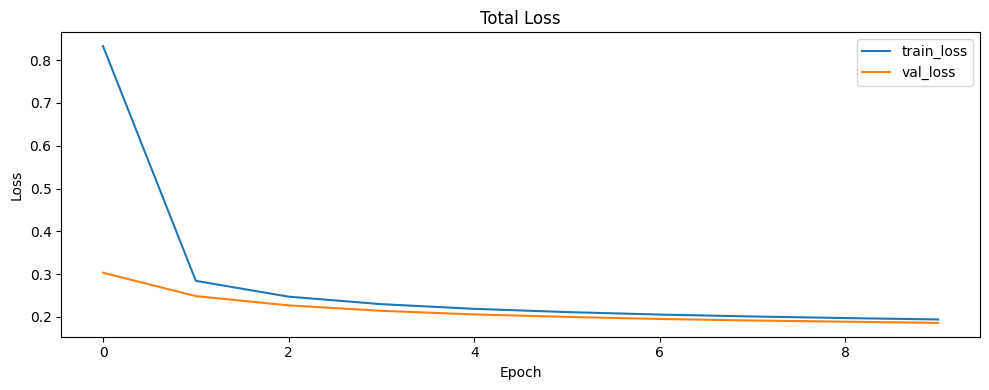

In [26]:
# Loss curve

plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'],   label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Total Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

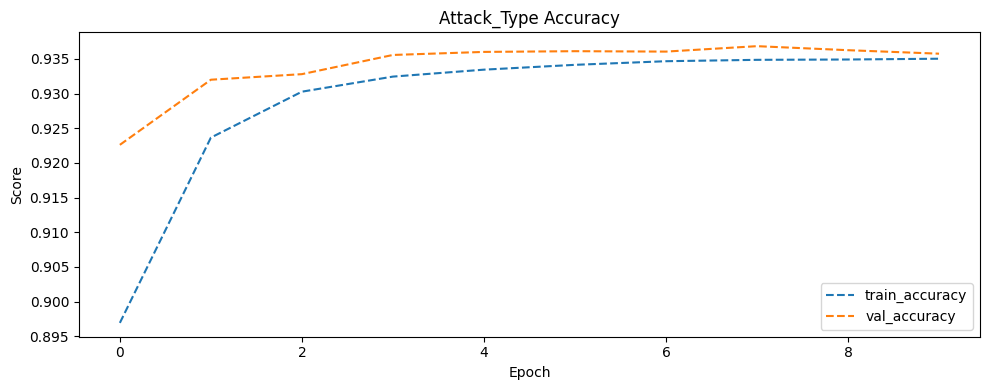

In [27]:
# type hhead metrics
plt.figure(figsize=(10, 4))
plt.plot(history.history['accuracy'],    '--', label='train_accuracy')
plt.plot(history.history['val_accuracy'], '--', label='val_accuracy')
plt.title('Attack_Type Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.legend()
plt.tight_layout()
plt.show()

In [28]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, classification_report,
    roc_curve, auc
)
from sklearn.preprocessing import label_binarize

In [30]:
# config
DATA_DIR       = '/kaggle/input/edgeiiotdataset/EdgeIioTDataset/'
CHECKPOINT_PTH = '/kaggle/working/best_type_model.keras'

print("📂 Files in dataset folder:", os.listdir(DATA_DIR))

📂 Files in dataset folder: ['val.csv', 'train.csv', 'test.csv']


In [31]:
# Load test dataset
test_df = pd.read_csv(os.path.join(DATA_DIR, 'test.csv'))
FEATURE_COLS = [c for c in test_df.columns if c not in ('Attack_label', 'Attack_type')]

X_test = test_df[FEATURE_COLS].astype('float32').values
y_true = test_df['Attack_type'].astype(int).values

In [32]:
# load trained model
model = tf.keras.models.load_model(CHECKPOINT_PTH, compile=False)

In [33]:
# Inferernce
y_probs = model.predict(X_test, batch_size=128)
y_pred = np.argmax(y_probs, axis=1)

# Metrics
accuracy  = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
recall    = recall_score(y_true, y_pred, average='macro', zero_division=0)
f1        = f1_score(y_true, y_pred, average='macro', zero_division=0)
report    = classification_report(y_true, y_pred, zero_division=0)

print("\n== ✅ TYPE-HEAD METRICS ==")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")
print("\n📊 Classification Report:\n", report)

# Multi-Class Roc Curve
num_classes = y_probs.shape[1]
y_true_bin = label_binarize(y_true, classes=np.arange(num_classes))

fpr, tpr, roc_auc = {}, {}, {}
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Micro-average ROC
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


3468/3468 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step

== ✅ TYPE-HEAD METRICS ==
Accuracy : 0.9368
Precision: 0.4930
Recall   : 0.5366
F1 Score : 0.5002

📊 Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    323129
           1       0.00      0.00      0.00       243
           2       0.58      0.37      0.46      7527
           3       0.00      0.00      0.00      2185
           4       0.45      0.17      0.25     10241
           5       0.70      0.99      0.82      9982
           6       0.67      1.00      0.80     10012
           7       0.40      0.77      0.53     10031
           8       0.00      0.00      0.00      4513
           9       0.93      0.84      0.88     10022
          10       0.69      0.91      0.78      4972
          11       0.00      0.00      0.00      3183
          12       0.00      0.00      0.00       200
          13       1.00      1.00      1.00     24314
          14       0

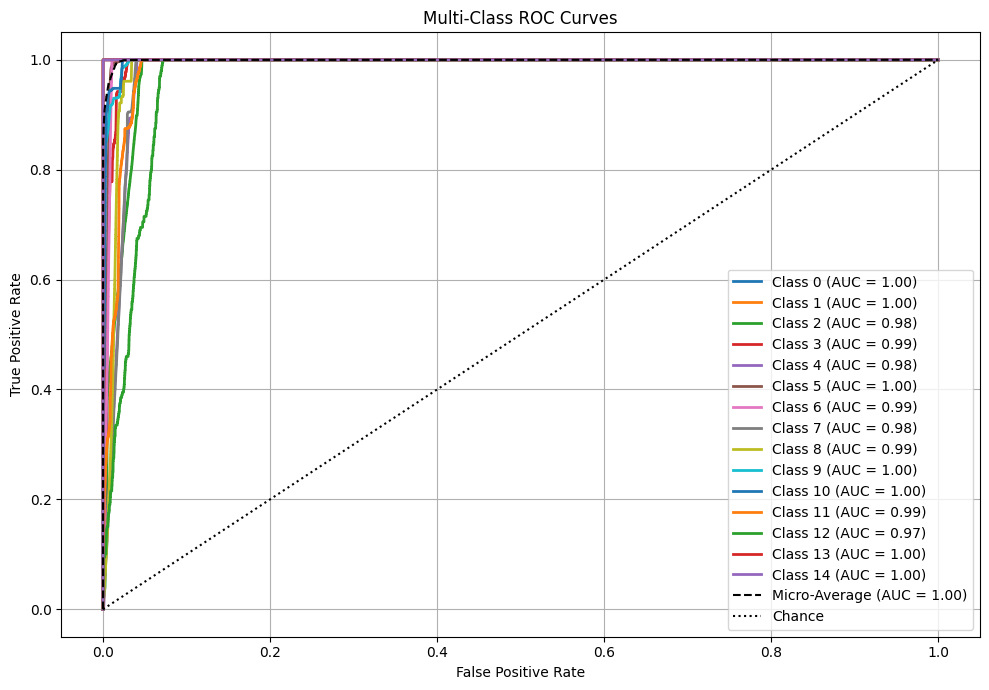

In [34]:
# Plot ROC Curve
plt.figure(figsize=(10, 7))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot(fpr["micro"], tpr["micro"], linestyle='--', color='black',
         label=f'Micro-Average (AUC = {roc_auc["micro"]:.2f})')

plt.plot([0, 1], [0, 1], 'k:', label='Chance')
plt.title('Multi-Class ROC Curves')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

In [35]:
model.save("intrusion_model.h5")